# Transfer Learning for Image Classification Using CNN
- [Introduction](#intro)
- [Part 1: Feature Extraction Using VGGNet](#part1)
- [Part 2: Neural Net Building and Training](#part2)
- [Part 3: Neural Net Testing](#part3)

<a id='intro'></a>
## Introduction

In this project, I'll show how to classify images using a pre-trained network with Tensorflow. I will use [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) (see below for a description of the full architecture), which was trained on the [ImageNet dataset](http://www.image-net.org/). 

Here, we will use the convolutional layers of VGGNet to extract features from our dataset. The dataset is composed of flower images (5 classes) and comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining). We will then train a small custom neural net of fully connected layers on those features. The network will use those features to learn to classify between our 5 classes of flowers.

The notebook consists of 3 parts: in Part 1 I'll extract the features from the flower images using VGGNet. In Part 2, I'll quickly preprocess the extracted features and will use them to train the neural net of fully connected layers described above. Finally, in Part 3, I will test the network trained in Part 2. An accuracy of ~96% is achieved. 

A VGG network implementation for Tensorflow can be found here: https://github.com/machrisaa/tensorflow-vgg. Please clone the repository to your working directory before proceding. Note: this contains the network and some useful functions, but not the trained parameters. We will download the parameters in one of the following sections.

<a id='part1'></a>
## Part 1: Feature Extraction Using VGGNet

Here is a schematic of VGGNet:

<img src="vgg16.png" width=650px>

For this project, we will use the convolutional layers of VGGNet to extract the features of the dataset. To do that, we will get the output of the first fully-connected layer of the pre-trained VGGNet when passing the flower images of our dataset through it. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import os
import numpy as np
import tensorflow as tf
import csv
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from scipy.ndimage import imread
import csv

First, we need to download the parameters for the pre-trained VGGNet:

In [2]:
# Make sure vgg depository was cloned
vgg_dir = 'tensorflow_vgg/'
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

# Define progress bar for download
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Download parameters file in vgg depository
if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [01:06, 8.27MB/s]                               


Let's then download the flower dataset:

In [3]:
import tarfile

dataset_folder_path = 'flower_photos'

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

Flowers Dataset: 229MB [00:04, 55.9MB/s]                              


This is the [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py) implementing VGGNet:

    self.conv1_1 = self.conv_layer(bgr, "conv1_1")
    self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
    self.pool1 = self.max_pool(self.conv1_2, 'pool1')

    self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
    self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
    self.pool2 = self.max_pool(self.conv2_2, 'pool2')

    self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
    self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
    self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
    self.pool3 = self.max_pool(self.conv3_3, 'pool3')

    self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
    self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
    self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
    self.pool4 = self.max_pool(self.conv4_3, 'pool4')

    self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
    self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
    self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
    self.pool5 = self.max_pool(self.conv5_3, 'pool5')

    self.fc6 = self.fc_layer(self.pool5, "fc6")
    assert self.fc6.get_shape().as_list()[1:] == [4096]
    self.relu6 = tf.nn.relu(self.fc6)

    self.fc7 = self.fc_layer(self.relu6, "fc7")
    self.relu7 = tf.nn.relu(self.fc7)

    self.fc8 = self.fc_layer(self.relu7, "fc8")

Here, we will need the output of the first fully-connected layer, i.e., self.relu6.

In the code below, I create batches of images from our dataset, which I then pass through VGGNet. I then save the output of relu6 as an array of codes.

In [5]:
# Extract classes from subfolders' names in folder dataset
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # Build the vgg network
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope('content_vgg'):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images from the center to resize it to the required input size for VGG
            img = utils.load_image(os.path.join(class_path, file)) # outputs ndarray # os.path.join(class_path, file) same as class_path+'|'+file
            batch.append(img.reshape((1, 224, 224, 3))) # format: [array([...]), array([...])] with each array being an image
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files): # whenever we have enough pictures in our batch or we've reached the end of the folder
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch) # format: [[...] [...]] with each [...] being an image
                
                # Get the values from the relu6 layer of the VGG network
                codes_batch = sess.run(vgg.relu6, feed_dict={input_: images})
                
                # Build an array of codes concatenated across batches
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)
print('codes and labels saved')

/output/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting daisy images


/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
420 images processed
430 images processed
440 images processed
450 images processed
460 images processed
470 images processed
480 images processed
4

<a id='part2'></a>
## Part 2: Neural Net Building and Training

Now that we have the output of VGGNet for each image, we need to build a small classifier consisting of a few fully-connected layers. First, a bit of data preprocessing:

In [6]:
# read codes and labels from file, if necessary
with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))
    
# one-hot encoding using LabelBinarizer from scikit-learn
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
labels_vecs = lb.transform(labels)

# shuffling the data using StratifiedShuffleSplit from scikit-learn (to keep the proportion of samples for each class)
# with 80% of data for training, 10% for validation and 10% for testing

# Split 80% training data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_idx, test_idx in sss.split(codes, labels_vecs):
    train_x, train_y = codes[train_idx], labels_vecs[train_idx]
    tmp_codes, tmp_labels = codes[test_idx], labels_vecs[test_idx]
    
# Split remaining 20% into validation and testing
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for train_idx, test_idx in sss.split(tmp_codes, tmp_labels):
    val_x, val_y = tmp_codes[train_idx], tmp_labels[train_idx]
    test_x, test_y = tmp_codes[test_idx], tmp_labels[test_idx]

Next, we can define our classifier. I will have a single hidden layer of 1024 units followed by a softmax layer.

In [9]:
# Define placeholders for inputs and targets
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

# Define hidden layer and output
num_hidden_units = 1024

fc = tf.contrib.layers.fully_connected(inputs_, num_hidden_units)
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)

# Define cost functiona and optimizer
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Define validation/testing accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Finally, let's train the classifier on batches of data.

In [12]:
num_epochs = 10
show_every_n_iterations = 10

saver = tf.train.Saver()
iteration = 0

# Yield batches
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        yield X, Y

with tf.Session() as sess:
        
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(num_epochs):
    
        for (x, y) in get_batches(train_x, train_y):
            feed = {inputs_: x,
                   labels_: y,
                   }
            _, loss = sess.run([optimizer, cost], feed_dict= feed)
            iteration += 1
            
            if iteration % show_every_n_iterations == 0:
                feed = {inputs_: val_x,
                       labels_: val_y,
                       }
            acc = sess.run(accuracy, feed_dict=feed)   
            print("Epoch: {}/{}".format(epoch_i, num_epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(acc),
                      "Training loss: {:.5f}".format(loss))
    
    saver.save(sess, "checkpoints/flowers.ckpt")
    print('Model Trained and Saved')

Epoch: 0/10 Iteration: 1 Validation Acc: 0.6451 Training loss: 5.38033
Epoch: 0/10 Iteration: 2 Validation Acc: 0.4096 Training loss: 30.14015
Epoch: 0/10 Iteration: 3 Validation Acc: 0.5188 Training loss: 50.59462
Epoch: 0/10 Iteration: 4 Validation Acc: 0.5119 Training loss: 42.51955
Epoch: 0/10 Iteration: 5 Validation Acc: 0.6928 Training loss: 23.39394
Epoch: 0/10 Iteration: 6 Validation Acc: 0.4778 Training loss: 11.40780
Epoch: 0/10 Iteration: 7 Validation Acc: 0.5666 Training loss: 11.03447
Epoch: 0/10 Iteration: 8 Validation Acc: 0.7235 Training loss: 6.97744
Epoch: 0/10 Iteration: 9 Validation Acc: 0.8157 Training loss: 2.72150
Epoch: 0/10 Iteration: 10 Validation Acc: 0.7084 Training loss: 3.43201
Epoch: 1/10 Iteration: 11 Validation Acc: 0.7782 Training loss: 1.65479
Epoch: 1/10 Iteration: 12 Validation Acc: 0.7338 Training loss: 2.94104
Epoch: 1/10 Iteration: 13 Validation Acc: 0.7031 Training loss: 3.68184
Epoch: 1/10 Iteration: 14 Validation Acc: 0.7406 Training loss: 2.9

<a id='part3'></a>
## Part 3: Neural Net Building and Training

Let's test the model:

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.9564


Let's try the network on a random image chosen below:

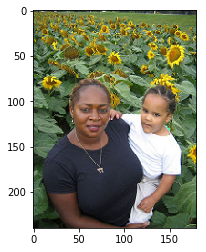

In [15]:
%matplotlib inline
test_img_path = 'flower_photos/sunflowers/40410686_272bc66faf_m.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [16]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [17]:
# Run VGGNet on the chosen image
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)

# Run the output of VGGNet on the classifier
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


The predicted class:

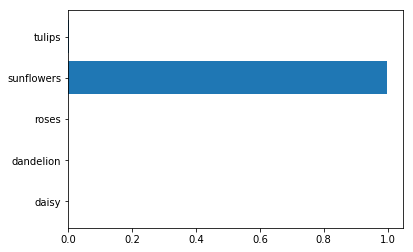

In [19]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)